In [1]:
# We define the data transformations and loaders to load the images and their corresponding
# labels from the training folder. We use the Adam optimizer and cross-entropy loss function for training.
# Finally, we train the model for 10 epochs and save the model weights.
# The training data is loaded using PyTorch's DataLoader, and the model is trained using the Adam optimizer and
# cross-entropy loss. The trained model is then saved to a file for later use.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

from model import GenderClassifier

In [3]:
# Define the data transformations and loaders
transform = transforms.Compose([
    transforms.Resize((12, 98)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train_set = datasets.ImageFolder('mfc_dataset_train_test/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)
classes = train_loader.dataset.classes

Feature batch shape: torch.Size([32, 1, 12, 98])
Labels batch shape: torch.Size([32])


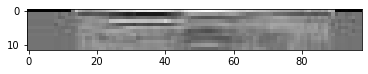

Label: 0 = female


In [4]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} = {classes[label]}")

In [7]:
# Initialize the model, loss function, and optimizer
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = GenderClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the model
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Save the model
torch.save(model.state_dict(), 'saved_model/weights')

Epoch 1, Loss: 0.3580154614376688
Epoch 2, Loss: 1.0831500261355513
Epoch 3, Loss: 0.6995161408052658
Epoch 4, Loss: 0.6992301919970649
Epoch 5, Loss: 0.6993988961838304
Epoch 6, Loss: 0.6996186049982381
Epoch 7, Loss: 0.6998278005435444
Epoch 8, Loss: 0.7000098093249165
Epoch 9, Loss: 0.7001556527500336
Epoch 10, Loss: 0.7002681328084903
Epoch 11, Loss: 0.7003534712349645
Epoch 12, Loss: 0.7004175161401304
Epoch 13, Loss: 0.7004652769801716
Epoch 14, Loss: 0.7005007156548789
Epoch 15, Loss: 0.7005268988517908
Epoch 16, Loss: 0.700546230371006
Epoch 17, Loss: 0.7005604747385262
Epoch 18, Loss: 0.7005709261178209
Epoch 19, Loss: 0.7005786425389421
Epoch 20, Loss: 0.7005842916500835


In [8]:
test_set = datasets.ImageFolder('mfc_dataset_train_test/test', transform=transform)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: {} %'.format(100 * correct / total))

Accuracy: 50.0 %
